In [5]:
import numpy as np
import scipy
import scipy.optimize as optimize
from matplotlib import animation
from IPython.display import HTML
import matplotlib.pyplot as plt
plt.rcParams['animation.writer'] = 'avconv'

## Image processing

In [7]:
dimension = 500
images = [np.array(scipy.misc.imread('./boat_{:02d}.jpg'.format(i+1))[::3,::5,:3][:dimension,:dimension,:],dtype=float)/255 for i in range(5)]

AttributeError: module 'scipy' has no attribute 'misc'

In [6]:
plt.close("all")
fig, axs = plt.subplots(1,4,figsize=(15,5))
for i in range(4):
    _ = axs[i].imshow(images[i])
plt.show()

NameError: name 'images' is not defined

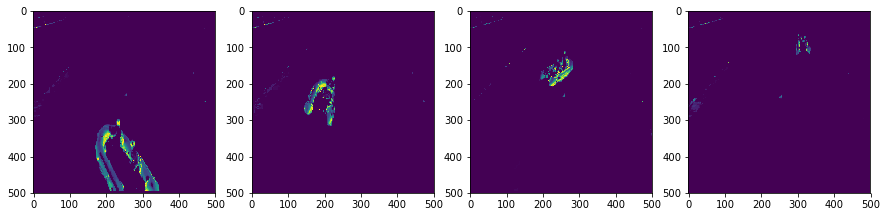

In [4]:
def getRed(img):
    red = np.clip(img[:,:,0] / (1e-10+np.sum(img,2)), a_min=0.5, a_max=1)
    return red

fig, axs = plt.subplots(1,4,figsize=(15,5))
for i in range(4):
    _ = axs[i].imshow(getRed(images[i]))
plt.show()

## Gauss function

$N(x,\mu,\sigma) = \exp\left( \frac{(x-\mu)^\top (x-\mu)}{-2 \sigma} \right)$

In [5]:
def gauss(x, mu, sigma):
    dot = (x[0] - mu[0])**2 + (x[1] - mu[1])**2
    return np.exp(-dot/(2*sigma**2))

def d_gauss_d_mu(x,mu,sigma):
    dot = (x[0] - mu[0])**2 + (x[1] - mu[1])**2
    return np.exp(-dot/(2*sigma**2)) * (x-mu[:,np.newaxis,np.newaxis])/sigma**2

In [6]:
sigma = 50
pixel_indices = np.linspace(0,dimension,dimension)
XY = np.stack(np.meshgrid(pixel_indices, pixel_indices))

gauss_example  = gauss(XY,mu=np.array([200,100]), sigma=50)
dZ = d_gauss_d_mu(XY,mu=np.array([200,100]), sigma=50)
XY.shape

(2, 500, 500)

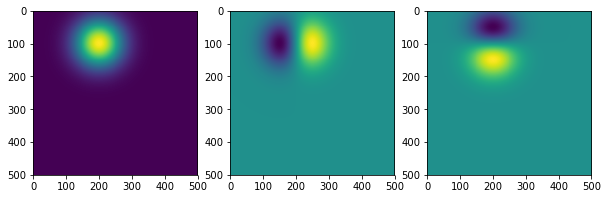

In [7]:
fig, axs = plt.subplots(1,3,figsize=(10,5))
axs[0].imshow(gauss_example)
axs[1].imshow(dZ[0,:,:])
axs[2].imshow(dZ[1,:,:])
plt.show()

## Energy function

$E(I,\mu,\sigma) = - \sum_\text{px} \text{Image}[\text{px}] \mathbf{\cdot} \text{Gauss}(\mu,\sigma)[\text{px}]$

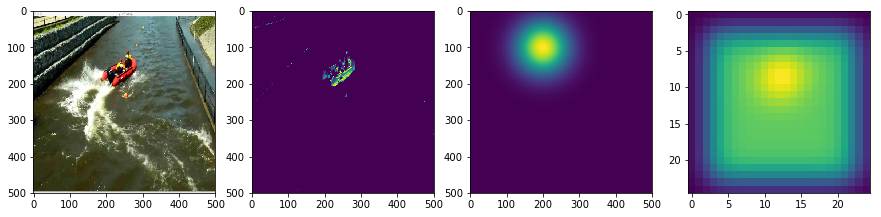

In [8]:
# the input image
img = images[2]

# extracting the red color
red = getRed(img)

# slide this Gaussian over the whole image (convolution)
def energy_single(mu):
    return - np.sum(red * gauss(XY,mu,sigma=sigma))
energy_map = np.array([[energy_single(np.array([mu_x,mu_y])) for mu_x in range(0,500,20)] for mu_y in range(0,500,20)])

#energy_image = np.array(energy).reshape(25,25)
plt.close("all")
fig, axs = plt.subplots(1,4,figsize=(15,5))
_ = axs[0].imshow(img)
_ = axs[1].imshow(red)
_ = axs[2].imshow(gauss_example)
_ = axs[3].imshow(np.power(-energy_map,4))
plt.show()

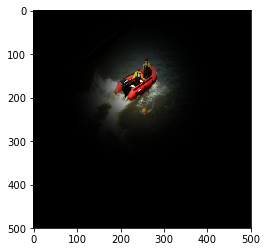

In [9]:
mu_opt = np.flipud(np.unravel_index(energy_map.argmin(), energy_map.shape))*20

gauss_window = gauss(XY,mu=mu_opt,sigma=sigma)
highlight = images[2]*gauss_window[:,:,np.newaxis]

plt.imshow(highlight)
plt.show()

## Optimizing the energy function

In [10]:
def opt_window(img, mu):
    def energy(mu):
        return - np.sum(img * gauss(XY,mu,sigma=sigma))
    
    return optimize.minimize(energy, mu).x
    
    #def d_energy_d_mu(mu):
    #    return - np.sum(img * d_gauss_d_mu(XY,mu,sigma=sigma),axis=(1,2)) 
    #return optimize.minimize(energy, mu, jac=d_energy_d_mu, method='Newton-CG').x

In [11]:
plt.close("all")
fig, axs = plt.subplots(1,3,figsize=(15,5))
anim_imgs = [axs[ai].imshow(gauss_window) for ai in range(3)]

def init():
    return anim_imgs

mu_opt = np.array([dimension/2,dimension/2])
def animate(i):
    global mu_opt
    # load and display video
    red = getRed(images[i])
    anim_imgs[1].set_array(red)

    # optimize blob position
    mu_opt = opt_window(red, mu_opt)
    
    # display highlighted result
    gauss_window = gauss(XY,mu=mu_opt, sigma=sigma)
    anim_imgs[2].set_array(images[i]*gauss_window.reshape(dimension,dimension,1))
    return anim_imgs

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=4, interval=1000, blit=True)

In [12]:
%%time
HTML(anim.to_html5_video())

CPU times: user 1.94 s, sys: 99.8 ms, total: 2.04 s
Wall time: 2.11 s
